# Fútbol bayesiano

Carga de librerías

In [14]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from cmdstanpy import CmdStanModel
from ipywidgets import widgets

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

Carga en memoria de los datos

In [4]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config['datos']['raw'])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'date'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # ------------------------------------ Transformación a columnas existentes
    .assign(
        date = lambda df_: pd.to_datetime(df_.date)
        ,home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863 entries, 21128 to 23890
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 863 non-null    datetime64[ns]
 1   tournament           863 non-null    object        
 2   home_team            863 non-null    category      
 3   away_team            863 non-null    category      
 4   home_team_continent  863 non-null    category      
 5   away_team_continent  863 non-null    category      
 6   home_team_score      863 non-null    int64         
 7   away_team_score      863 non-null    int64         
 8   result               863 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(3), object(1)
memory usage: 65.3+ KB


In [12]:
df_.head()

,date,tournament,home_team,away_team,home_team_continent,away_team_continent,home_team_score,away_team_score,result
21128,2019-06-06,FIFA World Cup qualification,Bhutan,Guam,Asia,Asia,1,0,1
21129,2019-06-06,FIFA World Cup qualification,Cambodia,Pakistan,Asia,Asia,2,0,1
21130,2019-06-06,FIFA World Cup qualification,Laos,Bangladesh,Asia,Asia,0,1,-1
21131,2019-06-06,FIFA World Cup qualification,Macau,Sri Lanka,Asia,Asia,1,0,1
21132,2019-06-06,FIFA World Cup qualification,Mongolia,Brunei Darussalam,Asia,Asia,2,0,1


# 2. Modelo en STAN

$$y^h\sim Poisson(\theta^h)$$
$$y^a\sim Poisson(\theta^a)$$
$$log(\theta^h) = home_{boost} + attack_{i[h]} - defence_{i[a]} + intercept$$
$$log(\theta^a) = attack_{i[a]} - defence_{i[h]} + intercept$$

## 2.1. Muestreo

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [5]:
import BFG3000 as bfg

In [6]:
name = 'dinam_juan'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Proyecto creado


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [45]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True)

Se delcara un diccionario de datos para proporcionar los datos a stan

In [46]:
encoder = LabelEncoder()
encoder.fit(pd.concat([df_['home_team'], df_['away_team']]))

df_['team1'] = encoder.transform(df_['home_team']) + 1  
df_['team2'] = encoder.transform(df_['away_team']) + 1

# Número de partidos y equipos
N = len(df_)
K = len(encoder.classes_)

data = {
  'N': N,
  'K': K,
  'team1': df_['team1'].tolist(),
  'team2': df_['team2'].tolist(),
  'y1': df_['home_team_score'].tolist(),
  'y2': df_['away_team_score'].tolist(),
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [48]:
fit_ = compile_.sample(
    data=data
    ,chains=3
    ,iter_warmup=5_000
    ,iter_sampling=5_000
    ,show_progress=True
    ,save_warmup=False
)

15:57:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

15:58:25 - cmdstanpy - INFO - CmdStan done processing.
15:58:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpv_kk81el/tmp2t9ad4zw.stan', line 37, column 2 to column 41)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpv_kk81el/tmp2t9ad4zw.stan', line 36, column 2 to column 39)
Consider re-running with show_console=True if the above output is unclear!


In [32]:
diagnose_path = os.path.join(dir_, name + '_diagnose.txt')

with open(diagnose_path, 'w') as file_:
    file_.write(fit_.diagnose())
file_.close()

## 2.2 Resumen de estimadores

In [33]:
summary_ = fit_.summary()
summary_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 829 entries, lp__ to defence[206]
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mean     829 non-null    float64
 1   MCSE     829 non-null    float64
 2   StdDev   829 non-null    float64
 3   5%       829 non-null    float64
 4   50%      829 non-null    float64
 5   95%      829 non-null    float64
 6   N_Eff    829 non-null    float64
 7   N_Eff/s  829 non-null    float64
 8   R_hat    829 non-null    float64
dtypes: float64(9)
memory usage: 64.8+ KB


Número de parámetros

In [34]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

summary_vis_.param.value_counts()

param
attack_raw       206
defence_raw      206
attack           206
defence          206
lp__               1
home               1
intercept          1
sigma_attack       1
sigma_defence      1
Name: count, dtype: int64

### 2.2.1 MCSE

Primero se observa el `MCSE` de lo parámetros únicos

In [35]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

single_params = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
).param.values.to_list()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,MCSE
0,lp__,0.285887
1,home,0.000353
2,intercept,0.000453
415,sigma_attack,0.000580
416,sigma_defence,0.000497


Visualización del error estándar MC de los parámetros múltiples

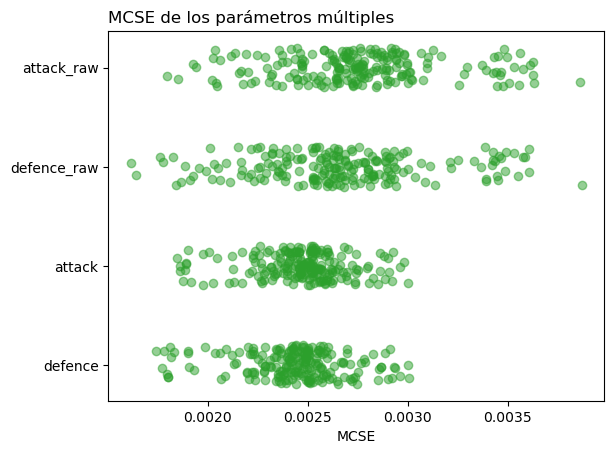

In [36]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.2 Número efectivo de simulaciones

Primero se observa el `N_Eff` de lo parámetros únicos

In [38]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,N_Eff
0,lp__,3674.070000
1,home,14481.300000
2,intercept,7688.720000
415,sigma_attack,4900.723711
416,sigma_defence,7965.132422


Visualización del error estándar MC de los parámetros múltiples

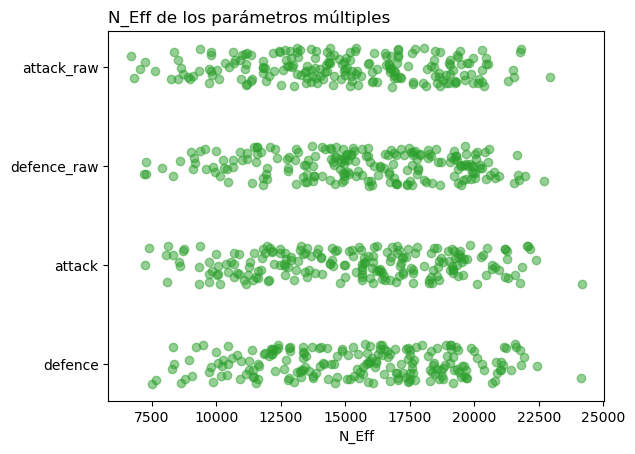

In [39]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.3 Factor de reducción de escala

Primero se observa el `R_hat` de lo parámetros únicos

In [40]:
# Datos de visualización
diagnostico = 'R_hat'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,R_hat
0,lp__,1.000550
1,home,1.000190
2,intercept,1.000380
415,sigma_attack,1.000047
416,sigma_defence,0.999884


Visualización del error estándar MC de los parámetros múltiples

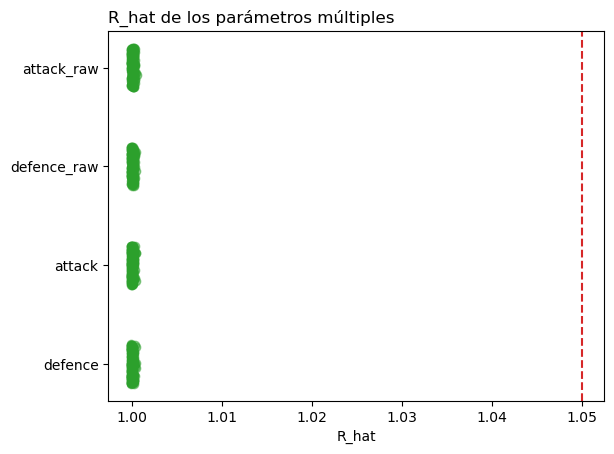

In [41]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)
ax.axvline(x=1.05, color='tab:red', linestyle='--')

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.4 Traza de las cadenas

In [42]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(5000, 3, 835)

Parámetros simples

In [43]:
def traceplot_single_param(param, type):
    idp_ = fit_.column_names.index(param)
    arr_ = chains_[:, :, idp_]

    # Especificaciones de figura
    plt.figure(figsize=(10,5))

    if type == 'traceplot':
        # Visualizaciones
        for chain in range(arr_.shape[1]):
            plt.plot(arr_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Traza de las cadenas, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    if type == 'convergence':
        ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
        ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

        # Visualizaciones
        for chain in range(ergo_.shape[1]):
            plt.plot(ergo_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Promedios ergódicos, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    plt.show()

In [44]:
widgets.interact(
    traceplot_single_param
    ,param=widgets.Dropdown(
        options=single_params
        ,description='Param'
        ,disabled=False)
    ,type=widgets.Dropdown(
        options=['traceplot','convergence']
        ,description='Type'
        ,disabled=False)
        
)

interactive(children=(Dropdown(description='Param', options=('lp__', 'home', 'intercept', 'sigma_attack', 'sig…

<function __main__.traceplot_single_param(param, type)>